In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing
from math import cos, sin
from sklearn.preprocessing import OneHotEncoder

# LR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# K-Means
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

In [4]:
# Load dataset

initial_dataset = pd.read_csv('House_Price_Prediction.csv')
initial_dataset.shape

(29451, 12)

In [5]:
initial_dataset.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


### Preprocessing

1. Removes irrelevant fields
2. Handles categorial variables
3. Converts latitude-longitude to xyz coordinates (for further clustering in next step)

In [7]:
# Remove unnecessary and overwritten columns

def cleanDF(data):
    clean_df = data.drop(['POSTED_BY', 'RERA', 'BHK_OR_RK', 'ADDRESS', 'LONGITUDE', 'LATITUDE'], axis=1, errors='ignore')
    return clean_df

In [8]:
# Handle categorical variables using OneHotEncoder
# : Generates new boolean fields based off possible categories of categorial variables

def handleCategoricalVariables(data):
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoded_data = encoder.fit_transform(data[['POSTED_BY', 'BHK_OR_RK']])
    column_names = encoder.get_feature_names_out(['POSTED_BY', 'BHK_OR_RK'])
    encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_data, columns=column_names)
    return encoded_df

In [9]:
# Converts latitute and longitude to 3D coordinates (x,y,z)

def get3DCoordinatesFromLatLong(lat, long):
    # If latitude and longitude are as strings
    # lat = (int)((lat.strip())[1:].split('°')[0])
    # long = (int)((long.strip())[1:].split('°')[0])

    r = 10000
    x = r * sin(lat) * cos(long)
    y = r * sin(lat) * sin(long)
    z = r * cos(lat)

    return (x, y, z)

In [10]:
# Preprocess dataset

def preprocessDF(data):
    cl_df = cleanDF(data)
    cl_df.rename(columns={'TARGET(PRICE_IN_LACS)': 'PRICE_IN_LACS'}, inplace=True)
    
    x = []
    y = []
    z = []
    for i in range(data.shape[0]):
        xyz = get3DCoordinatesFromLatLong(data.iloc[i,:]['LATITUDE'], data.iloc[i,:]['LONGITUDE'])
        x.append(xyz[0])
        y.append(xyz[1])
        z.append(xyz[2])
    cl_df['X'] = x
    cl_df['Y'] = y
    cl_df['Z'] = z

    cv_df = handleCategoricalVariables(data)

    processed_df = pd.concat([cl_df, cv_df], axis=1)

    return processed_df

In [11]:
processed_dataset = preprocessDF(initial_dataset)
processed_dataset.head()

,UNDER_CONSTRUCTION,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,PRICE_IN_LACS,X,Y,Z,POSTED_BY_Builder,POSTED_BY_Dealer,POSTED_BY_Owner,BHK_OR_RK_BHK,BHK_OR_RK_RK
0,0,2,1300.236407,1,1,55.0,7436.981766,3175.379663,-5882.879075,0.0,0.0,1.0,1.0,0.0
1,0,2,1275.000000,1,1,51.0,9077.611114,-2727.002340,3187.543679,0.0,1.0,0.0,1.0,0.0
2,0,2,933.159722,1,1,43.0,7704.573157,1655.566148,-6156.188204,0.0,0.0,1.0,1.0,0.0
3,0,2,929.921143,1,1,62.5,-8680.561413,-3346.574721,-3667.191185,0.0,0.0,1.0,1.0,0.0
4,1,2,999.009247,0,1,60.5,-4100.243098,-2811.460662,8676.617745,0.0,1.0,0.0,1.0,0.0


In [12]:
X = processed_dataset
Y = processed_dataset['PRICE_IN_LACS']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)

### Clustering
Clusters houses based off there xyz coordinates to seperate out localities 

In [14]:
X_train_xyz = X_train.loc[:,['X', 'Y', 'Z']]

In [15]:
# Find optimal k for KMeans clustering using Davies Bouldin score and Elbow method

k_optimal = 1
db_min = 1000

inertia = {}
db = {}
for k in range(2,50):
    kmeans = KMeans(n_clusters=k, max_iter=10000, random_state=322)
    kmeans.fit(X_train_xyz)
    labels = kmeans.predict(X_train_xyz)

    inertia[k] = kmeans.inertia_
    db[k] = davies_bouldin_score(X_train_xyz, labels)
    
    if db[k] < db_min:
        db_min = db[k]
        k_optimal = k

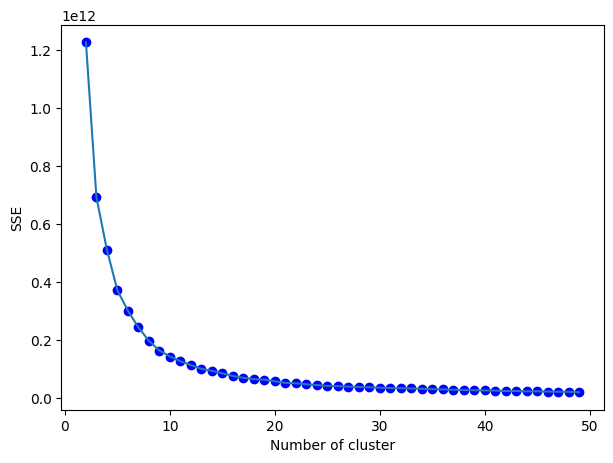

In [16]:
plt.figure(figsize=(7,5))
plt.plot(list(inertia.keys()), list(inertia.values()),'bo')
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

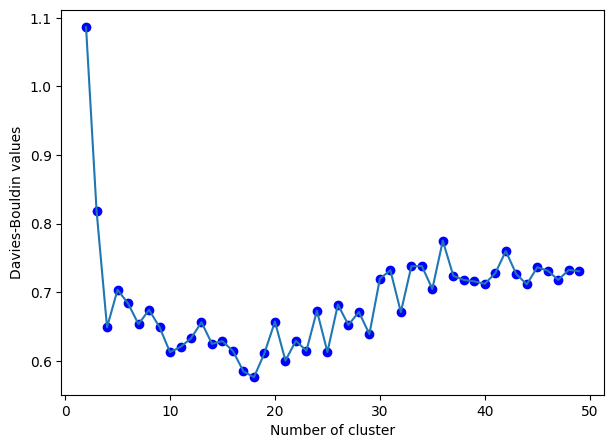

In [17]:
plt.figure(figsize=(7,5))
plt.plot(list(db.keys()), list(db.values()), 'bo')
plt.plot(list(db.keys()), list(db.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Davies-Bouldin values")
plt.show()

In [19]:
# Clustering into k_optimal localities

kmeans = KMeans(n_clusters=k_optimal, max_iter=100000, random_state=322)
kmeans.fit(X_train_xyz)
labels = kmeans.predict(X_train_xyz)

X_train['LOCALITY_ID'] = labels

In [21]:
# Adding LOCALITY_ID for each house in training dataset

localities = []
for locality_id in range(k_optimal):
    localities.append(X_train[X_train['LOCALITY_ID'] == locality_id])

### Linear Regression
Train different linear regression models for every locality

In [22]:
locality_LR = []
locality_LR_r2_score = []

for locality in localities:
    x = locality.drop(['LOCALITY_ID', 'X', 'Y', 'Z', 'PRICE_IN_LACS'], axis=1)
    y = locality['PRICE_IN_LACS']

    linear_reg = LinearRegression()
    linear_reg.fit(x, y)
    locality_LR.append(linear_reg)

    y_pred = linear_reg.predict(x)
    locality_LR_r2_score.append(r2_score(y, y_pred))

### Prediction

In [23]:
X_test_df = X_test.drop(['X', 'Y', 'Z', 'PRICE_IN_LACS'], axis=1)
price_predictions = {}

In [24]:
# Predicting price of a house in each locality based off the linear regression models trained for localities

for locality_id, lr in enumerate(locality_LR):
    price_predictions[f'LOCALITY_{locality_id}_PRICE'] = lr.predict(X_test_df)

In [25]:
price_predictions_df = pd.DataFrame(price_predictions)
price_predictions_df

,LOCALITY_0_PRICE,LOCALITY_1_PRICE,LOCALITY_2_PRICE,LOCALITY_3_PRICE,LOCALITY_4_PRICE,LOCALITY_5_PRICE,LOCALITY_6_PRICE,LOCALITY_7_PRICE,LOCALITY_8_PRICE,LOCALITY_9_PRICE,LOCALITY_10_PRICE,LOCALITY_11_PRICE,LOCALITY_12_PRICE,LOCALITY_13_PRICE,LOCALITY_14_PRICE,LOCALITY_15_PRICE,LOCALITY_16_PRICE,LOCALITY_17_PRICE
0,10.087375,1.352967,4.789396,-27.168585,17.656783,8.232548,-126.280557,9.304333,8.349773,8.549322,11.881138,42.202670,-85.075684,-9.662740,4.931677,13.983736,16.884213,-0.689541
1,40.643569,40.840519,35.761393,46.725969,38.831591,27.142644,56.605512,49.280699,32.408513,33.094974,38.646148,44.981613,11.226912,34.155091,30.326138,40.749801,42.493266,22.581335
2,30.299883,8.517366,31.708349,1.760597,24.523453,38.813712,-1.940607,33.032943,19.444523,29.793505,84.674552,80.341416,47.127561,13.592311,48.450155,28.793602,53.676059,14.443426
3,91.349576,66.575826,74.732606,149.504059,50.906045,47.537415,314.558410,76.716338,40.905819,66.804277,121.652254,65.444604,227.657399,81.663816,83.700418,69.623697,91.075502,11.129902
4,60.893192,60.386764,73.880101,75.682171,55.150123,74.947807,210.113250,94.479359,59.282695,61.490364,121.237895,95.228752,150.578300,68.991369,83.042902,63.078782,87.465228,67.226704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7358,60.879853,55.936562,69.854759,75.672460,51.752997,68.757270,199.629955,86.762735,53.611355,58.920124,117.716243,90.876833,148.009161,64.828921,79.736914,60.376311,84.525185,56.619550
7359,40.658522,45.829048,40.273668,46.736855,42.639657,34.082030,68.356938,57.930780,38.765897,35.976128,42.593804,49.859970,14.106831,38.821058,34.032041,43.779182,45.788958,34.471603
7360,60.810428,32.775246,48.904647,75.621915,34.072470,36.538288,145.069081,46.601147,24.094559,45.543169,99.387611,68.227035,134.637940,43.165233,62.530722,46.311155,69.223570,1.414046
7361,91.407539,85.913428,92.224052,149.546259,65.667684,74.437348,360.111799,110.247627,65.549671,77.972822,136.955002,84.355133,238.821158,99.751034,98.066030,81.366829,103.850965,57.221498
